<a href="https://colab.research.google.com/github/therineliu/recyclability-identifier/blob/main/recycle_or_trash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) 2022 AIClub

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated
documentation files (the "Software"), to deal in the Software without restriction, including without
limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so, subject to the following
conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial
portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT
LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO
EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN
AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE
OR OTHER DEALINGS IN THE SOFTWARE.

Follow our courses - https://www.corp.aiclub.world/courses



In [15]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [16]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [17]:
!git clone https://github.com/therineliu/recyclability-identifier

Cloning into 'recyclability-identifier'...


In [1]:

# Please replace the brackets below with the drive location of your folder which included subfolders for images
# Sample path: /content/drive/My Drive/ImageClassification
PATH = '/content/recycletrash'


In [9]:
def create_model(base_model, num_classes):
    import tensorflow as tf
    # Grab the last layer and add a few extra layers to it
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    # Dense layer 1
    x=tf.keras.layers.Dense(100,activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling(), use_bias=True)(x)

    x=tf.keras.layers.Dense(100,activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling(), use_bias=True)(x)

    # Final layer with softmax activation
    preds=tf.keras.layers.Dense(num_classes,activation='softmax', kernel_initializer=tf.keras.initializers.VarianceScaling(), use_bias=False)(x)

    # Create the final model
    model=Model(inputs=base_model.input,outputs=preds)
    return model


In [10]:
def get_optimizer(optimizer_name, learning_rate):
    # Import keras optimizers
    from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad, Adamax, Ftrl, Nadam, RMSprop, SGD
    print('Selected Optimizer', optimizer_name)
    switcher = {
        'Adadelta': Adadelta(learning_rate=learning_rate),
        'Adagrad': Adagrad(learning_rate=learning_rate),
        'Adam': Adam(learning_rate=learning_rate),
        'Adamax': Adamax(learning_rate=learning_rate),
        'FTRL': Ftrl(learning_rate=learning_rate),
        'NAdam': Nadam(learning_rate=learning_rate),
        'RMSprop': RMSprop(learning_rate=learning_rate),
        'Gradient Descent': SGD(learning_rate=learning_rate)
    }
    # If optimizer_name is empty, Adam will be return as default optimizer
    return switcher.get(optimizer_name, Adam(learning_rate=learning_rate))


In [14]:
# Import packages needed to create a imaage classification model
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping
from tensorflow import keras

# Initialize hyper params
epochs = 5  #<-- increase for higher accuracy
base_learning_rate = 0.005 #decrease for different results; use excel sheet to note down results from each change to learning rate and epochs
optimizer = 'Adam'
BATCH_SIZE = 32

IMG_SIZE = (224, 224)

# Create the data generation pipeline for training and validation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(PATH,
                                                target_size=IMG_SIZE,
                                                color_mode='rgb',
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                shuffle=True,
                                                subset = 'training')
validation_generator = train_datagen.flow_from_directory(PATH,
                                                target_size=IMG_SIZE,
                                                color_mode='rgb',
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                shuffle=True,
                                                subset = 'validation')

# Download the model, valid alpha values [0.25,0.35,0.5,0.75,1]
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', alpha=0.35)
for layer in base_model.layers:
    layer.trainable=False

#for layer in base_model.layers[:160]:
    #layer.trainable=False
#for layer in base_model.layers[160:]:
    #layer.trainable=True

# Dynamically get the number of classes from the training generator
num_classes = train_generator.num_classes

# Create the base model
model = create_model(base_model,num_classes)

model.save("my_model.h5")

print(len(base_model.layers))

model.compile(optimizer = get_optimizer(optimizer_name=optimizer,learning_rate=base_learning_rate),loss='CategoricalCrossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=30,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

step_size_train = train_generator.n//train_generator.batch_size
history_fine = model.fit(train_generator,
                        epochs=epochs,
                        callbacks=[early_stopping_monitor],
                        validation_data = validation_generator,
                        verbose=1)

Found 26 images belonging to 3 classes.
Found 6 images belonging to 3 classes.


154
Selected Optimizer Adam


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.1154 - loss: 1.2329 - val_accuracy: 0.6667 - val_loss: 0.6319
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9231 - loss: 0.4038 - val_accuracy: 0.5000 - val_loss: 1.1833
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6923 - loss: 0.5946 - val_accuracy: 1.0000 - val_loss: 0.1815
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step - accuracy: 0.9615 - loss: 0.0819 - val_accuracy: 0.5000 - val_loss: 1.0170
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9231 - loss: 0.2217 - val_accuracy: 0.8333 - val_loss: 0.6071


In [12]:

# Import numpy for calculating best model accuracy
import numpy as np
# Populating matrics -> accuracy & loss
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

print('Training Accuracy: ', acc)
print('Validation Accuracy: ', val_acc)
print('Training Loss: ', loss)
print('Validation Loss: ', val_loss)
best_model_accuracy = history_fine.history['val_accuracy'][np.argmin(history_fine.history['val_loss'])]
print('best model accuracy: ', best_model_accuracy)


Training Accuracy:  [0.5384615659713745, 0.8846153616905212, 0.692307710647583, 0.9615384340286255, 0.8461538553237915]
Validation Accuracy:  [0.8333333134651184, 0.5, 0.8333333134651184, 0.5, 0.6666666865348816]
Training Loss:  [0.8865474462509155, 0.260734885931015, 0.5692733526229858, 0.049017272889614105, 0.321860134601593]
Validation Loss:  [0.4431574046611786, 1.4965559244155884, 0.324439138174057, 2.1518003940582275, 0.6864859461784363]
best model accuracy:  0.8333333134651184


In [6]:
def seperate_labels(generator):
    x_validation = []
    y_validation = []
    num_seen = 0

    for x, labels in generator:
        x_validation.append(x)
        y_validation.append([argmax(label) for label in labels])
        num_seen += len(x)
        if num_seen == generator.n: break

    x_validation = np.concatenate(x_validation)
    y_validation = np.concatenate(y_validation)
    return x_validation, y_validation


/tmp/ipython-input-3264777856.py:3: DeprecationWarning: numpy.core.fromnumeric is deprecated and has been renamed to numpy._core.fromnumeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.fromnumeric.argmax.
  from numpy.core.fromnumeric import argmax


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (3).

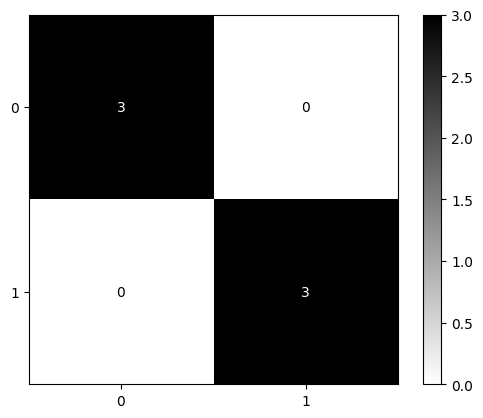

In [7]:

# Calculate and display the confusion matrix
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import argmax
from sklearn.metrics import ConfusionMatrixDisplay

x_validation, y_validation = seperate_labels(validation_generator)
y_pred = model.predict(x_validation, batch_size=BATCH_SIZE)
predictions = np.apply_along_axis(argmax, 1, y_pred)
display_labels = validation_generator.class_indices.keys()

ConfusionMatrixDisplay.from_predictions(y_validation, predictions, display_labels=display_labels, cmap="binary")
plt.show()


In [8]:
# Predicting code for an image
from tensorflow.keras.preprocessing import image
# Please replace the brackets below with the location of your image which need to predict
img_path = '/content/recyclee.jpeg'
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = model.predict(img_preprocessed)

# Get the predicted class index (the one with the highest probability)
predicted_class_index = np.argmax(prediction)

# Get the class labels from the training generator
class_labels = list(train_generator.class_indices.keys())

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

print(f"The predicted class is: {predicted_class_label}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/recyclee.jpeg'

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


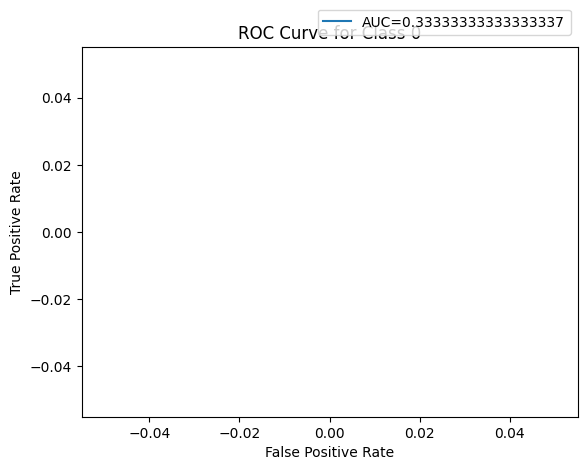

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming the first class (index 0) is the positive class for ROC calculation
# You can change the index to calculate ROC for a different class
positive_class_index = 0

# Get the true labels
y_true = validation_generator.classes

# Get the probability predictions for the positive class
predictions = y_pred[:, positive_class_index]

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, predictions, pos_label=positive_class_index)
auc = roc_auc_score(y_true, predictions)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(f'ROC Curve for Class {positive_class_index}')
plt.legend(bbox_to_anchor=(1, 1.12))
plt.show()